<a href="https://colab.research.google.com/github/sabughnaim/Machine-Learning-Classification/blob/master/ML_Unit_04_classification_Sara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div id="container" style="position:relative;">
<div style="float:left"><h1> Unit 04: Classification </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

#### Classification algorithms we will cover:
- Logistic Regression
- Support Vector Machine
- Decision Trees
- Ensemble methods: Random Forests, Gradient Boosting


#### Troubleshooting tips:
- Dealing with unbalanced classes
- Dealing with high cardinality





In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
pd.options.display.max_columns=500
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [0]:
def PlotBoundaries(model, X, Y) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    '''
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y,s=100, edgecolor='k') 
    plt.show()

The data we will work with in this section came from https://www.kaggle.com/blastchar/telco-customer-churn. You can find it in the class portal.

In [0]:
df = pd.read_csv('/Users/SXA5KCD/Documents/ML Class/Telco-Customer-Churn.csv', index_col=0)

In [0]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Convert categoricals to numeric

As you may recall from the *Intro to Data Science* class, these algorithms cannot handle categorical data natively. So we must first convert all categorical data into numeric, using encoding

In [0]:
df['gender'] = np.where(df['gender'] == 'Female', 0, 1) #if a null, it will keep it a null. but should check for that first 
df['Partner'] = np.where(df['Partner'] == 'No', 0, 1)
df['Dependents'] = df['Dependents'].map({'No':0,
                                         'Yes':1})
df['PhoneService'] = df['PhoneService'].map({'No':0, 'Yes':1})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'No':0, 'Yes':1})
df = pd.get_dummies(df, columns=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod'])
df['Churn']=df['Churn'].map({'No':0, 'Yes':1})
df['TotalCharges'] = pd.to_numeric(np.where(df['TotalCharges']==' ', 0, df['TotalCharges']))

### Feature universe

here we define a list of the feature universe from which the models can select top features

In [0]:
features_to_include = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


### Feature Selection

We have a full universe from which to select features, and we can use an algorithm to pick the best features to include in the model.

We will see that in order to visualize the boundary nicely, it makes the most sense in 2 dimensions. So keep only 2 features, using a **feature selection** package from scikit-learn. The package we will use uses a non-parametric approach to rank features by their Mutual Information shared with the target.

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [0]:
from sklearn import feature_selection

In [0]:
feature_rank = feature_selection.mutual_info_classif(df[features_to_include], df['Churn'])

In [0]:
feature_rank_df = pd.DataFrame(list(zip(features_to_include, feature_rank)), columns=['Feature', 'Score'])

In [0]:
feature_rank_df.sort_values(by='Score', ascending = False).head(7)
#this means that the top ones are the most related to churn and leaving the phone company 
#been longer with the company, shopping around

,Feature,Score
33,Contract_Month-to-month,0.093862
4,tenure,0.077315
15,OnlineSecurity_No,0.058304
35,Contract_Two year,0.056714
24,TechSupport_No,0.052732
13,InternetService_Fiber optic,0.048673
7,MonthlyCharges,0.046312


in reality we should choose Contract_Month-to-month as the best feature, but the values are binary and don't make nice plots when we visualize the separation between points. So I will choose the first 2 continuous variables:

In [0]:
two_features = ['tenure','MonthlyCharges']

### Split into test/train

In [0]:
#randomely takes 40% for testing
X_trn, X_tst, Y_trn, Y_tst = train_test_split(df[features_to_include], df['Churn'], test_size=0.4)

## Logistic Regression

Logistic Regression is one of the most basic (yet effective) tools we have for classifying categorical data.

With *linear* regression, we modelled data using linear equations of the form: 

$$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d $$

This equation outputs numerical predictions from numerical input attributes. Recall that each $\beta_i$ represents how much our model weighs $x_i$ in predicting the output values. 

How can we modify this function to get *categorical* predictions? 

With Logistic Regression, we take advantage of the **sigmoid curve**:
$$ s(X) = \frac{1}{1+e^{-f(X)}} $$

In [0]:
#If S(x) is 1/2, then predictability is low and youre likely to classify wrong. it's a toss up
logreg = sk.linear_model.LogisticRegression()
logreg.fit(df[features_to_include],df['Churn'])
logreg.score(df[features_to_include],df['Churn'])

0.8047706943064035

this means that loking at the full dataset, i have 80% accuracy. not splitting into train and test 

But remember, we shouldn't validate our hypothesis on the same data that we use to generate our hypothesis. So we should be splitting our data into test and train!

In [0]:
logreg = sk.linear_model.LogisticRegression()
logreg.fit(X_trn[features_to_include],Y_trn)

print('accuracy on training data',logreg.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',logreg.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.802603550295858
accuracy on test data 0.8087295954577715


Recall we can use this model to predict values on the unseen dataset

In [0]:
pred_probs = logreg.predict_proba(X_tst[features_to_include])
preds = logreg.predict(X_tst[features_to_include])

In [0]:
pred_probs

array([[0.9846537 , 0.0153463 ],
       [0.99101167, 0.00898833],
       [0.94119903, 0.05880097],
       ...,
       [0.95553475, 0.04446525],
       [0.98269015, 0.01730985],
       [0.20954628, 0.79045372]])

In [0]:
preds #[[0.42183473, 0.57816527] | 0.4 is lower than 0.57 so it set it to 1

array([0, 0, 0, ..., 0, 0, 1])

As mentioned, visualization makes the most sense in 2 dimensions, so we choose the 2 feature model:

In [0]:
logreg2features = sk.linear_model.LogisticRegression().fit(X_trn[two_features],Y_trn)

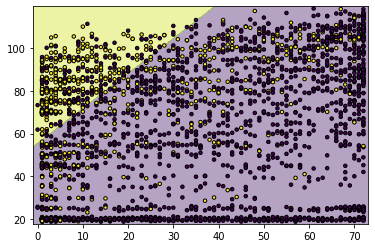

In [0]:
PlotBoundaries(logreg2features,X_tst[two_features].values,Y_tst)

### SVM

sara writing class: usage of SVMs are very low 
Reuben has never used them. this is something that was popular in late 90s and early 2000s.

there are much more powerful algos

finds the line that has the largest distance between the closest data points. it perturbs the line until it finds it optimally

Similar to Logistic Regression, Support Vector Machines draw a straight line boundary between the two classes. But while logistic regression applies a sigmoid transformation on the boundary and picks a threshold, SVM optimizes the separation between classes by moving the line. 

While initially linear boundaries can seem like a limitation, we will see that Kernel methods can first map the data to a higher dimensional space, where a straight line in a different dimensional space can be non-linear when converted back.

In [0]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC()
SVM_model.fit(X_trn[features_to_include], Y_trn)

print('accuracy on training data',SVM_model.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',SVM_model.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.7155029585798817
accuracy on test data 0.7033356990773598


similar performance to linear logistic regression because theyre doing the same thing 

In [0]:
svm_model_2feat = LinearSVC()
svm_model_2feat.fit(X_trn[two_features], Y_trn)
 
print('accuracy on training data',svm_model_2feat.score(X_trn[two_features], Y_trn))
print('accuracy on test data',svm_model_2feat.score(X_tst[two_features], Y_tst))

accuracy on training data 0.7917159763313609
accuracy on test data 0.7782114975159687


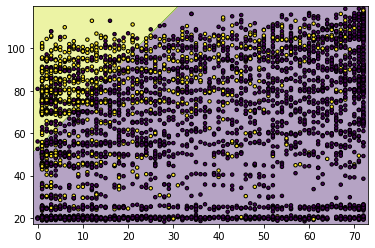

In [0]:
PlotBoundaries(svm_model_2feat, X_trn[two_features].values,Y_trn) 

the SVM's lineis shifted horizintally down from logistic regression 

### Kernel SVMs

SVM's draw straight line boundaries, but we can get around this limitation by first mapping our problem to a higher dimensional space. Then, a straight line drawn in the different space can get mapped back to a nonlinear boundary between classes. This mapping function is called a *Kernel*. The only drawback of this technique is we need to specify the Kernel, which is not always intuitive for our problems. Luckily Scikit-Learn has provided some built-in Kernels, such as the *Radial Basis Function*.

In [0]:
from sklearn.svm import SVC

kernel_SVM_model = SVC(kernel='rbf') #radial basis function mapping
kernel_SVM_model.fit(X_trn[features_to_include], Y_trn)

print('accuracy on training data',kernel_SVM_model.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',kernel_SVM_model.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.7384615384615385
accuracy on test data 0.7288857345635202


In [0]:
#when using the two features 
kernel_svm_model_2feat = SVC(kernel='rbf')
kernel_svm_model_2feat.fit(X_trn[two_features], Y_trn)
 
print('accuracy on training data',kernel_svm_model_2feat.score(X_trn[two_features], Y_trn))
print('accuracy on test data',kernel_svm_model_2feat.score(X_tst[two_features], Y_tst))

accuracy on training data 0.7950295857988166
accuracy on test data 0.7785663591199432


may not be linearly separable when mapping to a higher dimension. but the clean fit may not exist when looking at it in 2D 
relationship doesnt necessarily exist in original data.

there are more performant approaches

In [0]:
PlotBoundaries(kernel_svm_model_2feat, X_tst[two_features].values,Y_tst) 

## Decision Trees

Decision trees will be familiar to anyone who has played 20 Questions:  one player thinks of something (a person, an object, a place, etc.), and the other player tries to guess what it is by asking up to 20 questions that have yes or no answers.  Based on the answers you receive, you're able to eliminate many possible solutions (e.g.: if the answer to "animal?" is "yes", but the answer to "does it have four legs?" is "no", then clearly it cannot be a pig, or a sheep, or a cow, or a dog, or...), and hopefully arrive at the answer.

<img src="https://drive.google.com/uc?export=view&id=19hGt8Y11SBMk1rhm2x--2gf4o-bfoNPe" width=500px height=300px/>

The tree is made up of *nodes* (with the top being the *root* node), and each node represents a test on the attributes (e.g.: is the colour 'red' / is the weight under 10lbs?). 

Decision trees are an example of a hierarchal model. Each node in the tree represents an accumulation of information (from the nodes above it).

Once we reach a leaf node, a node with no children, we make our decision. A leaf node represents a decision we are sure about (or at least confident about).

In general decision trees don't care about the underlying feature types. For continuious features we can split on arbitrary values. If some independent variable has a continuious feature value $x_i$ the split can be on an value $v$, all examples where $x_i \leq v$ end up on the left branch while all values $x_i \geq v$ end up on the right branch. For discrete features we can split on class values.

Let's build a decision tree (using the `tree` package):

sara: cant have diagonal lines. only splits on x or y axis 

can specify what the minimum number of datapoints are in each cut , so the model knows when to stop
the more splits you do, the more time it takes 
each time youre doing the split, increase depth
Splits it so the data is more homogenous in separate sections than it was in the uncut section
deciding where to pu the line is computationally intensive. so drawing a line takes time 

2 ways of controlling for overfitting. 
Control the depth
Control the size of the number of samples you're willing to accept in each section 
The higher the number, the less likely it is to overfit 

2 knobs at your disposal: depth, size of samples in each split
Can outperform neural network models sometimes 
Tree based can tell you a linear relationship to the data too

In [0]:
from sklearn import tree

In [0]:
#fitting the DT
DT_model = tree.DecisionTreeClassifier()
DT_model.fit(df[features_to_include], df['Churn'])

DT_model.score(df[features_to_include], df['Churn'])

0.9974442709072838

In [0]:
#just with the two chosen features 
DT_model_2feat = tree.DecisionTreeClassifier()
DT_model_2feat.fit(df[two_features], df['Churn'])
PlotBoundaries(DT_model_2feat, df[two_features].values, df['Churn']) 

NameError: name 'PlotBoundaries' is not defined

Decision trees on their own are very prone to overfitting, as we can already tell from the 2 feature boundary plot. Again we shouldn't validate our hypothesis on the same data that we used to generate it, so let's use the test/train data

In [0]:
DT_model = tree.DecisionTreeClassifier()
DT_model.fit(X_trn[features_to_include], Y_trn)

print('accuracy on training data',DT_model.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',DT_model.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.9985798816568048
accuracy on test data 0.7207239176721079


Notice the drop off in accuracy using unseen data - this is a sign of **overfitting** on the training data

### Regularization

The way to control overfitting is via a technique called pre-pruning. We set various limits for how deep trees can become during the fitting. There is another popular technique called post-pruning where we trim down long tree branches after it has been fitted, but this is not implemented in `sklearn`.

There are two pre-pruning techniques we will look at:
1. Using `max_depth` we limit the number of consecutive splits that can be made. This directly limits the overall complexity of the tree, it can't develop overly complex branches for each individual data point.
2. Using `min_samples_leaf` we put a lower bound on the number of data points each region must cover. This forces the tree to fit regions around large amounts of data, also preventing specific regions to form for each individual data point. 

Both techniques can work well, for a more indepth look see: http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use.

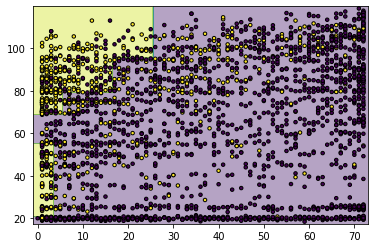

In [0]:
#depth of 5 means no lmore tan 5 cuts. and no less than 50 in each cell
DT_model_2feat = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)
DT_model_2feat.fit(df[two_features], df['Churn'])
PlotBoundaries(DT_model_2feat, X_tst[two_features].values,Y_tst) 

In [0]:
DT_model_2feat = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=50)
DT_model_2feat.fit(X_trn[two_features], Y_trn)

print('accuracy on training data',DT_model_2feat.score(X_trn[two_features], Y_trn))
print('accuracy on test data',DT_model_2feat.score(X_tst[two_features], Y_tst))

accuracy on training data 0.7794082840236687
accuracy on test data 0.7902767920511


Notice how much simpler our boundaries are, and how there was minimal dropoff in accuracy on unseen data

### visualizing trees

We can visualize the tree that was constructed, but we'll need to install two new packages for visualization, including a program.  Follow these steps:
1. Download Graphviz for your operating system: https://graphviz.gitlab.io/download/
2.  From the Anacona prompt, run `conda install graphviz`
3.  Then run `conda install pydotplus`

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

With our fitted model (`DT_model`) we can run the following script to visualize the tree:

make splits such that when you get lower nodes, shoudl have lower impurity
goal is to group similar items together 

the ratio of one class to another should decrease 
each subsection is more pure 

the ginni impurity index should decrease with each decision cut . if it's close to 0.5, then the likelihood of geting the classificaiton right is a flip of coin. th elower the better


class = no and class = yes

whenever second value is larger, it says yes

The value in the chart is the number of datapoints in each set of cut 

for any new values that fall within that cell, you can classify

for regression type problems 

1. predict the new value, buy taking the average of the values in cell

For classification: 
1. look at labels, and the prediction is the most common thing in that section

In [0]:
dot_data = StringIO()
export_graphviz(DT_model_2feat, out_file=dot_data, feature_names=two_features, class_names=['no','yes'],
               rounded=True, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Ensemble methods

**Random Forests**: build many decision trees in parallel, use voting to smartly combine the outputs back into 1 model. A subset (sample) of the total data is used for each tree, with aggregation (bagging) at the end to bring everything together.

**Boosted Trees**: build many decision trees in series, where the subsequent model is built on the error from the previous model. In this configuration, additional models are fit on the effects that were not captured in the previous model. Then at the end, the different models are added together to give the final result.

#### Random Forests

In [0]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=50, max_depth=5)
random_forest_model.fit(X_trn[features_to_include], Y_trn)
 
print('accuracy on training data',random_forest_model.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',random_forest_model.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.805680473372781
accuracy on test data 0.7998580553584103


In [0]:
random_forest_model_2feat = RandomForestClassifier(n_estimators=50, max_depth=5,)
random_forest_model_2feat.fit(X_trn[two_features], Y_trn)
 
print('accuracy on training data',random_forest_model_2feat.score(X_trn[two_features], Y_trn))
print('accuracy on test data',random_forest_model_2feat.score(X_tst[two_features], Y_tst))

accuracy on training data 0.7945562130177515
accuracy on test data 0.7980837473385379


In [0]:
PlotBoundaries(random_forest_model_2feat, X_tst[two_features].values,Y_tst) 

One advantage of tree-based machine learning methods is they provide a ranking of feature importances, which really helps with interpretability of the model

In [0]:
df_feat_importances = pd.DataFrame(list(zip(features_to_include,random_forest_model.feature_importances_)), columns=['Feature','Importance'])
df_feat_importances.sort_values(by='Importance', inplace=True)

one way of feature sleection in big datasets, is to create small models and look at feature importance

the best model for tabular data is GradientBoostingClassifier

scikitlearn has limitation that dataset has to fit on one VM

In [0]:
plt.figure(figsize=[6,8])
plt.barh(df_feat_importances['Feature'],df_feat_importances['Importance'])
#in regression it's the increase i nthe mean squared error. 
#in classification it's increase in accuracy. Reuben is checking on this

#### Gradient Boosted Trees

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=100)
gbm_model.fit(X_trn[features_to_include], Y_trn)
 
print('accuracy on training data',gbm_model.score(X_trn[features_to_include], Y_trn))
print('accuracy on test data',gbm_model.score(X_tst[features_to_include], Y_tst))

accuracy on training data 0.8298224852071006
accuracy on test data 0.8105039034776437


In [0]:
gbm_model_2feat = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=100)
gbm_model_2feat.fit(X_trn[two_features], Y_trn)
 
print('accuracy on training data',gbm_model_2feat.score(X_trn[two_features], Y_trn))
print('accuracy on test data',gbm_model_2feat.score(X_tst[two_features], Y_tst))

accuracy on training data 0.8002366863905326
accuracy on test data 0.801277501774308


In [0]:
PlotBoundaries(gbm_model_2feat, X_tst[two_features].values,Y_tst) 

again we can take a look at feature importances

In [0]:
df_feat_importances_gbm = pd.DataFrame(list(zip(features_to_include,gbm_model.feature_importances_)), columns=['Feature','Importance'])
df_feat_importances_gbm.sort_values(by='Importance', inplace=True)

In [0]:
plt.figure(figsize=[6,8])
plt.barh(df_feat_importances_gbm['Feature'],df_feat_importances_gbm['Importance'])

## Classification Tips

#### high cardinality

If a column has high cardinality, it has a large number of unique values. If a column 50with high cardinality is used, its very likely that it is too detailed to generalize well, and the model will be overfit to the training data.

In order to combat high cardinality (e.g. zip codes): 
- use domain knowledge to group those features into lower cardinality groups such as states or regions (e.g. north-eastern US).
- keep the most frequent values (e.g. top 10) and group the rest into an "other" bucket

If have large number of unique values (high cardinality) of categorical variables:
- create a column that is sparse with high amount of 0s and small amoun tof 1s
- need to create sparse columns to convert it to numberical value 

then the liklihood of splitting on a column is very low becasue theres not much data in the column 

#### Unbalanced classes

If the distribution of the target variable is very skewed (e.g. very few 1's and a lot of 0's), then it will throw off the typical metrics used to validate the performance of a model.

For example, if the occurrence rate of the 1 class is only 1%, then you could call EVERYTHING a 0 and you would be right 99% of the time. This has high accuracy, but is a completely useless model.

One way to combat unbalanced classes is to oversample (e.g. create duplicates) of the lower occurence class, and undersample the higher occurrence class, so that the occurence rate is closer to balanced.

resampling takes 2 flavors
- take the most common in a proportion that is equivalent to the rare. so they have the same proportion . ex: 98% negative cases. 2% positive cases. can say ok im only going to take 2% of the negative cases. downfall is that you lose a lot fo information from the data you dropped 
- resample with replacement with your minority class until it is approx same size as your majority class. downfall is that you cant accurately predict new cases because youre reusing the rare cases. 

# Assignment 4

Import the file `mushrooms.csv`. More info can be found here: https://www.kaggle.com/uciml/mushroom-classification/version/1
 - clean the data, convert categoricals
 - use a feature selection algorithm to reduce the feature space
 - try all the classification algorithms discussed above. Which performs the best (by accuracy score)?

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>


In [0]:
mushroom = pd.read_csv('/Users/SXA5KCD/Documents/ML CLass/mushrooms.csv')
#want normal index, no on column 1 

In [0]:
#mushroom.rename(columns={"class": "poisonous"})
sorted(mushroom['habitat'].unique())

['d', 'g', 'l', 'm', 'p', 'u', 'w']

In [0]:
mushroom['cap-shape'] = mushroom['cap-shape'].map({'b':1, 'c':2, 'f':3, 'k':4,'s':5, 'x':6})
mushroom['cap-surface'] = mushroom['cap-surface'].map({'f':40, 'g':30, 's':20, 'y':10})
mushroom['cap-color'] = mushroom['cap-color'].map({'b':10, 'c':9, 'e':8, 'g':7, 'n':6, 'p':5, 'r':4, 'u':3, 'w':2, 'y':1})
mushroom['bruises'] = mushroom['bruises'].map({'f':0, 't':1})
mushroom['odor'] = mushroom['odor'].map({'a':94, 'c':76, 'f':59, 'l':63, 'm':28, 'n':19, 'p':35, 's':41, 'y':88})
mushroom['gill-attachment'] = mushroom['gill-attachment'].map({'a':2, 'f':4})
mushroom['gill-spacing'] = mushroom['gill-spacing'].map({'c':100, 'w':50})
mushroom['gill-size'] = mushroom['gill-size'].map({'b':17, 'n':22})
mushroom['gill-color'] = mushroom['gill-color'].map({'b':12, 'e':11, 'g':10, 'h':9, 'k':8, 'n':7, 'o':6, 'p':5, 'r':4, 'u':3, 'w':2, 'y':1})
mushroom['stalk-shape'] = mushroom['stalk-shape'].map({'e':50, 't':100})
mushroom['stalk-root'] = mushroom['stalk-root'].map({'?':0, 'b':40, 'c':80, 'e':120, 'r':160})
mushroom['stalk-surface-above-ring'] = mushroom['stalk-surface-above-ring'].map({'f':11, 'k':22, 's':33, 'y':44})
mushroom['stalk-surface-below-ring'] = mushroom['stalk-surface-below-ring'].map({'f':40, 'k':30, 's':20, 'y':10})
mushroom['stalk-color-above-ring'] = mushroom['stalk-color-above-ring'].map({'b':2.1, 'c':4.1, 'e':6.1, 'g':8.1, 'n':10.1, 'o':12.1, 'p':14.1, 'w':16.1, 'y':18.1})
mushroom['stalk-color-below-ring'] = mushroom['stalk-color-below-ring'].map({'b':9, 'c':10, 'e':11, 'g':12, 'n':13, 'o':14, 'p':15, 'w':16, 'y':17})
mushroom['veil-type'] = mushroom['veil-type'].map({'p':714})
mushroom['veil-color'] = mushroom['veil-color'].map({'n':27, 'o':15, 'w':25, 'y':11})
mushroom['ring-number'] = mushroom['ring-number'].map({'n':17, 'o':12, 't':27})
mushroom['ring-type'] = mushroom['ring-type'].map({'e':478, 'f':765, 'l':896, 'n':302, 'p':984})
mushroom['spore-print-color'] = mushroom['spore-print-color'].map({'b':38, 'h':39, 'k':40, 'n':41, 'o':42, 'r':43, 'u':44, 'w':45, 'y':46})
mushroom['population'] = mushroom['population'].map({'a':-2, 'c':-4, 'n':-6, 's':-8, 'v':-10, 'y':-12})
mushroom['habitat'] = mushroom['habitat'].map({'d':63, 'g':64, 'l':65, 'm':66, 'p':67, 'u':68, 'w':69})

In [0]:
mushroom['class'] = mushroom['class'].map({'p':200, 'e':100})

In [0]:
mushroom.tail(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
8119,100,4,20,6,0,19,2,100,17,1,50,0,33,20,12.1,14,714,15,12,984,38,-4,65
8120,100,6,20,6,0,19,2,100,17,1,50,0,33,20,12.1,14,714,27,12,984,38,-10,65
8121,100,3,20,6,0,19,2,100,17,7,50,0,33,20,12.1,14,714,15,12,984,38,-4,65
8122,200,4,10,6,0,88,4,100,22,12,100,0,33,30,16.1,16,714,25,12,478,45,-10,65
8123,100,6,20,6,0,19,2,100,17,1,50,0,33,20,12.1,14,714,15,12,984,42,-4,65


In [0]:
mushroom[mushroom.duplicated()]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


There are no duplicated rows to clean.

In [0]:
mushroom.odor.count()
mushroom.columns
feature_universe = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

In [0]:
#use a feature selection algorithm to reduce the feature space
from sklearn import feature_selection
feature_importance = feature_selection.mutual_info_regression(mushroom[feature_universe],mushroom['class'])
feat_importance = pd.DataFrame(list(zip(feature_universe,feature_importance)), columns=['feature','importance'])
feat_importance.sort_values(by='importance', ascending=False, inplace=True)
feat_importance

,feature,importance
4,odor,0.610353
19,spore-print-color,0.325213
8,gill-color,0.297241
18,ring-type,0.235663
11,stalk-surface-above-ring,0.197822
12,stalk-surface-below-ring,0.187566
7,gill-size,0.172429
14,stalk-color-below-ring,0.171174
13,stalk-color-above-ring,0.166242
3,bruises,0.139791


In [0]:
top_features = [x for x in feat_importance['feature'][0:5]]
print(top_features)
top_two_features = [x for x in feat_importance['feature'][0:2]]
top_two_features

['odor', 'spore-print-color', 'gill-color', 'ring-type', 'stalk-surface-above-ring']


['odor', 'spore-print-color']

In [0]:
#try all the classification algorithms discussed above. Which performs the best (by accuracy score)?

x_train, x_test, y_train, y_test = train_test_split(mushroom[feature_universe], mushroom['class'], test_size=0.4)

### Logistic Regression

In [0]:
logreg = sk.linear_model.LogisticRegression()
logreg.fit(x_train[feature_universe],y_train)

print('accuracy on training data',logreg.score(x_train[feature_universe],y_train))
print('accuracy on test data',logreg.score(x_test[feature_universe], y_test))

accuracy on training data 0.9181370537546163
accuracy on test data 0.9166153846153846


In [0]:
#on two features
logreg.fit(x_train[top_two_features],y_train)

print('accuracy on training data',logreg.score(x_train[top_two_features],y_train))
print('accuracy on test data',logreg.score(x_test[top_two_features], y_test))

accuracy on training data 0.8526877308165778
accuracy on test data 0.848


In [0]:
prediction_probabilities = logreg.predict_proba(x_test[feature_universe]) #Probability estimates
predictions = logreg.predict(x_test[feature_universe])
prediction_probabilities
prediction_probabilities[3]

array([0.9989142, 0.0010858])

In [0]:
predictions[3]
x_test[2:3]
mushroom[5089:5090]
predictions

array([200, 100, 200, ..., 200, 200, 200])

In [0]:
logreg2features = sk.linear_model.LogisticRegression().fit(x_train[top_two_features],y_train)

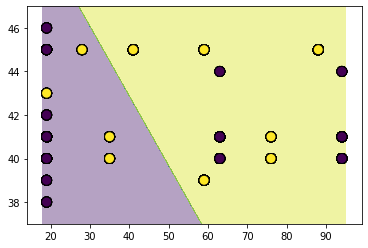

In [0]:
PlotBoundaries(logreg2features,x_test[top_two_features].values,y_test)

#### The x axis is odor and the y axis is spore print color 

### SVM

In [0]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC()
SVM_model.fit(x_train[feature_universe], y_train)

print('accuracy on training data with SVM, whole feature universe',"\n", SVM_model.score(x_train[feature_universe], y_train))
print('accuracy on test data with SVM',"\n", SVM_model.score(x_test[feature_universe], y_test))

accuracy on training data with SVM, whole feature universe 
 0.9290110791957324
accuracy on test data with SVM 
 0.9304615384615385


In [0]:
svm_model_2feat = LinearSVC()
svm_model_2feat.fit(x_train[top_two_features], y_train)
 
print('accuracy on training data, SVM, two features',svm_model_2feat.score(x_train[top_two_features], y_train))
print('accuracy on test data',svm_model_2feat.score(x_test[top_two_features], y_test))

accuracy on training data, SVM, two features 0.8526877308165778
accuracy on test data 0.848


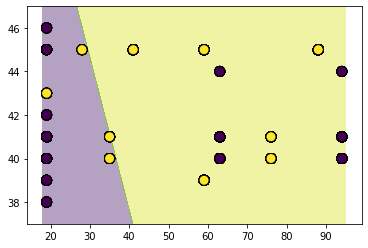

In [0]:
PlotBoundaries(svm_model_2feat, x_train[top_two_features].values,y_train)

##### a bunch of data points are showing on top of each other, since the categories are discrete 


In [0]:
len(x_train)

4874

### Kernel SVM

In [0]:
from sklearn.svm import SVC

kernel_SVM_model = SVC(kernel='rbf') #radial basis function mapping
kernel_SVM_model.fit(x_train[feature_universe], y_train)

print('accuracy on training data, kernel SVM, whole universe',kernel_SVM_model.score(x_train[feature_universe], y_train))
print('accuracy on test data',kernel_SVM_model.score(x_test[feature_universe], y_test))

accuracy on training data, kernel SVM, whole universe 0.8715633976200247
accuracy on test data 0.8541538461538462


In [0]:
from sklearn.svm import SVC

kernel_SVM_model_2feat = SVC(kernel='rbf') #radial basis function mapping
kernel_SVM_model_2feat.fit(x_train[top_two_features], y_train)

print('accuracy on training data, kernel SVM, two features',kernel_SVM_model_2feat.score(x_train[top_two_features], y_train))
print('accuracy on test data',kernel_SVM_model_2feat.score(x_test[top_two_features], y_test))

accuracy on training data, kernel SVM, two features 0.9864587607714403
accuracy on test data 0.9833846153846154


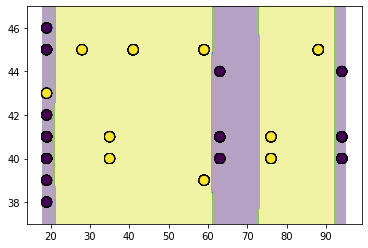

In [0]:
PlotBoundaries(kernel_SVM_model_2feat, x_test[top_two_features].values,y_test) 

### Decision Tree without Regularization

In [0]:
#fitting the DT
from sklearn import tree
DT_model = tree.DecisionTreeClassifier()
DT_model.fit(mushroom[feature_universe], mushroom['class'])

DT_model.score(mushroom[feature_universe], mushroom['class'])

1.0

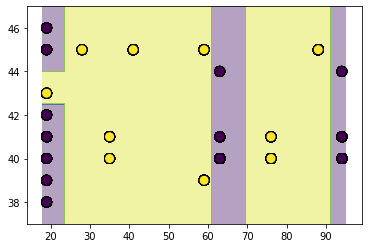

0.9940915805022157

In [0]:
DT_model_2feat = tree.DecisionTreeClassifier()
DT_model_2feat.fit(mushroom[top_two_features], mushroom['class'])
PlotBoundaries(DT_model_2feat, mushroom[top_two_features].values, mushroom['class']) 
DT_model_2feat.score(mushroom[top_two_features], mushroom['class'])

In [0]:
DT_model = tree.DecisionTreeClassifier()
DT_model.fit(x_train[feature_universe], y_train)

print('accuracy on training data, decision tree, feat univ',DT_model.score(x_train[feature_universe], y_train))
print('accuracy on test data',DT_model.score(x_test[feature_universe], y_test))

accuracy on training data, decision tree, feat univ 1.0
accuracy on test data 1.0


### Decision Tree with Regularization

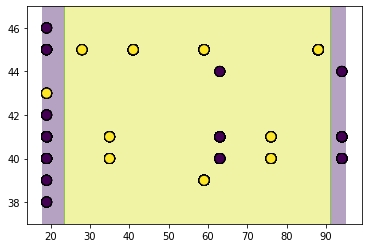

0.9359921221073363

In [0]:
DT_model_2feat_reg = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=100) #changing depth and min samples
DT_model_2feat_reg.fit(mushroom[top_two_features], mushroom['class'])
PlotBoundaries(DT_model_2feat_reg, x_test[top_two_features].values,y_test) 
DT_model_2feat_reg.score(mushroom[top_two_features], mushroom['class'])

In [0]:
DT_model_2feat_reg.fit(x_train[top_two_features], y_train)

print('accuracy on training data, decision tree regularized, 2 feats, with depth 3 and min samples 100',DT_model_2feat_reg.score(x_train[top_two_features], y_train))
print('accuracy on test data',DT_model_2feat_reg.score(x_test[top_two_features], y_test))

accuracy on training data, decision tree regularized, 2 feats 0.9357816988100123
accuracy on test data 0.9363076923076923


In [0]:
DT_model_2feat_reg2 = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)
DT_model_2feat_reg2.fit(x_train[feature_universe], y_train)

print('accuracy on training data, decision tree regularized, feat univ, with depth 4 and min samples 50',DT_model_2feat_reg2.score(x_train[feature_universe], y_train))
print('accuracy on test data',DT_model_2feat_reg2.score(x_test[feature_universe], y_test))

accuracy on training data, decision tree regularized, feat univ, with depth 4 and min samples 50 0.9924086992203529
accuracy on test data 0.9916923076923077


### Visualize Decision Tree

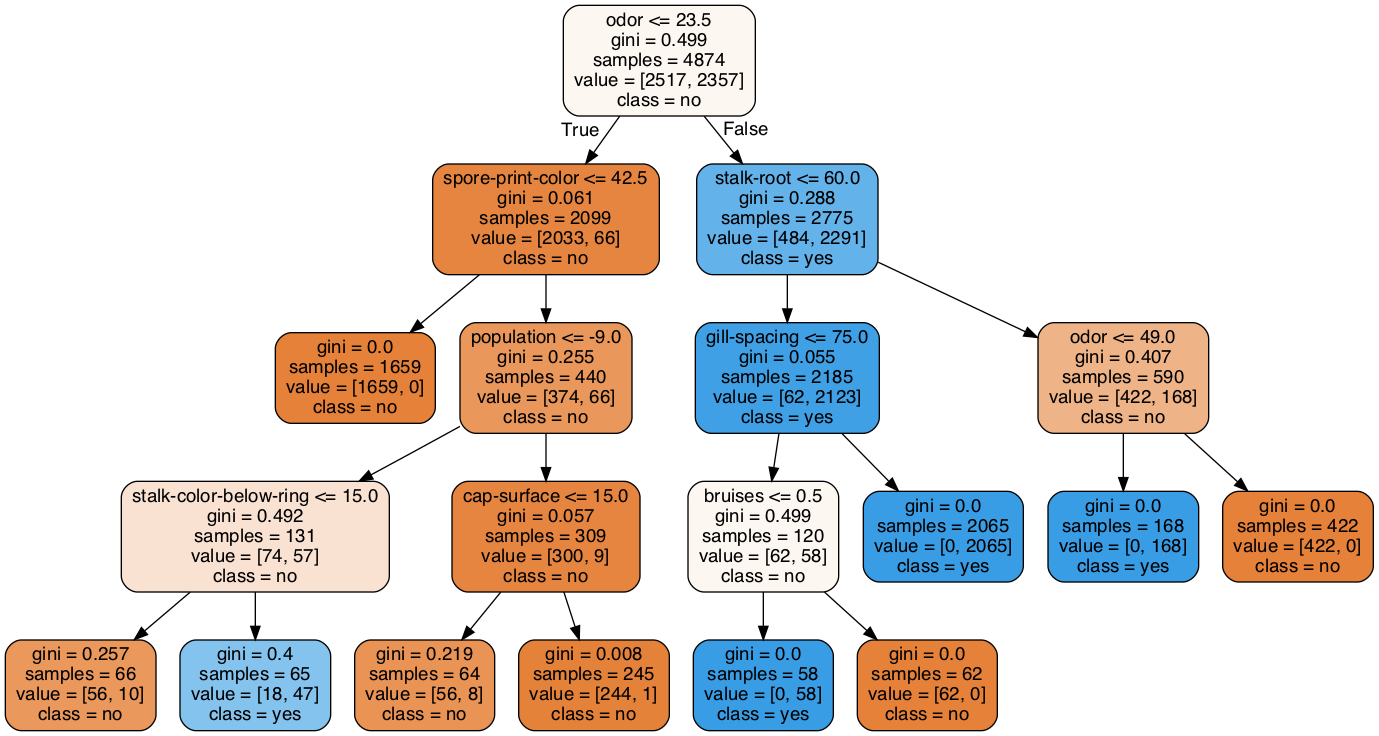

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(DT_model_2feat_reg2, out_file=dot_data, feature_names=feature_universe, class_names=['no','yes'],
               rounded=True, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### (Ensemble) Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=50, max_depth=5)
random_forest_model.fit(x_train[feature_universe], y_train)
 
print('accuracy on training data, random forest, feat univ',random_forest_model.score(x_train[feature_universe], y_train))
print('accuracy on test data',random_forest_model.score(x_test[feature_universe], y_test))

accuracy on training data, random forest, feat univ 0.9909725071809602
accuracy on test data 0.9913846153846154


In [0]:
random_forest_model_2feat = RandomForestClassifier(n_estimators=50, max_depth=5,)
random_forest_model_2feat.fit(x_train[top_two_features], y_train)
 
print('accuracy on training data, random forest, 2 feats',random_forest_model_2feat.score(x_train[top_two_features], y_train))
print('accuracy on test data',random_forest_model_2feat.score(x_test[top_two_features], y_test))

accuracy on training data, random forest, 2 feats 0.9690192860073862
accuracy on test data 0.9726153846153847


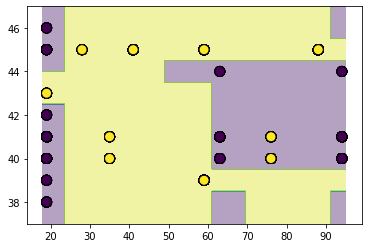

In [0]:
PlotBoundaries(random_forest_model_2feat, x_test[top_two_features].values, y_test)

In [0]:
df_feat_importances = pd.DataFrame(list(zip(feature_universe,random_forest_model.feature_importances_)), columns=['Feature','Importance'])
df_feat_importances.sort_values(by='Importance', inplace=True)
(pd.DataFrame(list(zip(feature_universe,random_forest_model.feature_importances_)), columns=['Feature','Importance'])).sort_values(by='Importance')

,Feature,Importance
15,veil-type,0.000000
16,veil-color,0.001966
5,gill-attachment,0.002844
0,cap-shape,0.004798
1,cap-surface,0.004881
9,stalk-shape,0.010043
17,ring-number,0.012603
13,stalk-color-above-ring,0.014227
14,stalk-color-below-ring,0.015305
21,habitat,0.018491


<BarContainer object of 22 artists>

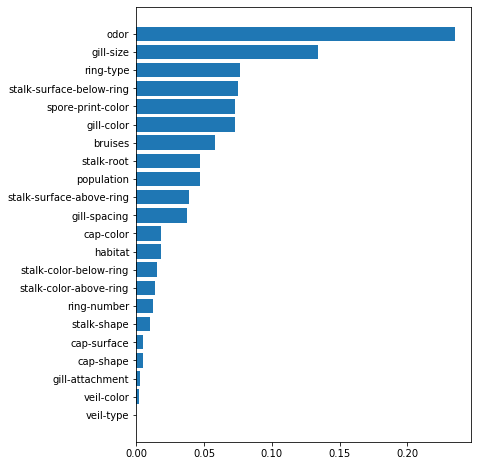

In [0]:
plt.figure(figsize=[6,8])
plt.barh(df_feat_importances['Feature'],df_feat_importances['Importance'])

### (Ensemble) Gradient Boosted Tree

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=100)
gbm_model.fit(x_train[feature_universe], y_train)
 
print('accuracy on training data, GBT, feat univ',gbm_model.score(x_train[feature_universe], y_train))
print('accuracy on test data',gbm_model.score(x_test[feature_universe], y_test))

accuracy on training data, GBT, feat univ 1.0
accuracy on test data 1.0


In [0]:
gbm_model_2feat = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=100)
gbm_model_2feat.fit(x_train[top_two_features], y_train)
 
print('accuracy on training data, GBT, 2 feats',gbm_model.score(x_train[top_two_features], y_train))
print('accuracy on test data',gbm_model.score(x_test[top_two_features], y_test))

accuracy on training data, GBT, 2 feats 0.9842018875666804
accuracy on test data 0.9867692307692307


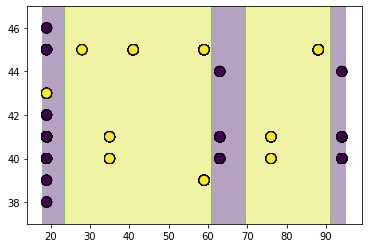

In [0]:
PlotBoundaries(gbm_model_2feat, x_test[top_two_features].values,y_test) 

In [0]:
df_feat_importances_gbm = pd.DataFrame(list(zip(feature_universe,gbm_model.feature_importances_)), columns=['Feature','Importance'])
df_feat_importances_gbm.sort_values(by='Importance', inplace=True)
df_feat_importances_gbm

,Feature,Importance
1,cap-surface,0.015053
0,cap-shape,0.984947


<BarContainer object of 2 artists>

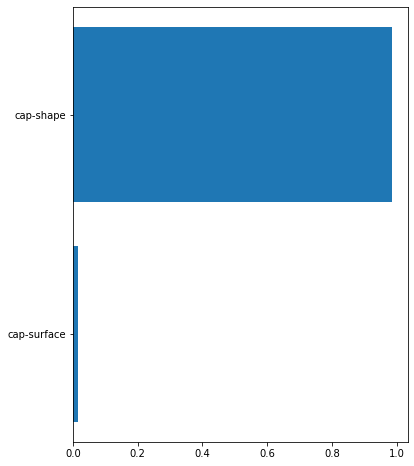

In [0]:
plt.figure(figsize=[6,8])
plt.barh(df_feat_importances_gbm['Feature'],df_feat_importances_gbm['Importance'])

In [0]:
comparing_algos= pd.DataFrame({'score on training data': [0.927,0.853, 0.929, 0.853, 0.872, 0.986, 
                                                          'N/A', 'N/A', 0.994, 1.0, '0.9357', 
                                                          0.975, 0.992, 0.995, 0.972, 1, 0.984],
                               
                               'score on test data': [0.927, 0.848, 0.930, 0.848, 0.854, 0.983, 1, 0.994, 
                                                      '0.9938',1.0, 0.936, 0.972, '0.9917', 0.990, 0.968, 1, 0.987 ]},
                            
                              index=['Logistic Regression', 'Logistic Regression top 2 features',
                               'SVM whole feat univ', 'SVM top 2 features', 'Kernel SVM feat univ',
                              'Kernel SVM top 2 features','Decision tree feat univ', 'Decision tree top 2 features without training', 
                               'decision tree top 2 with training', 'Decision tree, feat univ, with training', 
                                     'decision tree regularized, 2 feats, with depth 3 and min samples 100',
                                    'decision tree regularized, feat univ, with depth 3 and min samples 100', 
                                     'decision tree regularized, feat univ, with depth 4 and min samples 50', 
                                     'random forest, feat univ', 'random forest, 2 feats', 'GBT, feat univ', 'GBT, 2 feats'])
comparing_algos

,score on training data,score on test data
Logistic Regression,0.927,0.927
Logistic Regression top 2 features,0.853,0.848
SVM whole feat univ,0.929,0.93
SVM top 2 features,0.853,0.848
Kernel SVM feat univ,0.872,0.854
Kernel SVM top 2 features,0.986,0.983
Decision tree feat univ,N/A,1
Decision tree top 2 features without training,N/A,0.994
decision tree top 2 with training,0.994,0.9938
"Decision tree, feat univ, with training",1,1


#### These do a good job: Decision trees, all ensemble methods

#### SVMs and Logistic Regression are less performant

#### The top 2 features does not increase the score in most algorithms. The only algo that performs better with top 2 features is Kernel SVM

#### Decision trees, Logistic Regression, GBT, Random Forest, and SVM perform better with the whole feature universe than with the top 2 features 